In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.distributions import Beta
%matplotlib inline
import numpy as np
import pandas as pd
import sys
import os
import random
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import utils
import evaluate
import cs236781.plot as plot

In [2]:
def ELBO_loss(recon_x, x, mu, logvar, beta=1, b1 = 255, a1 = 0, distr='normal'):
    recon_error = nn.functional.mse_loss(recon_x, x, reduction='sum') / x.size(0)
    #recon_error = evaluate.reconstruction_loss(recon_x,x)
    #recon_error = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum') / x.size(0)

    if distr == "normal":
        kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), axis=1) / x.size(0)
    elif distr == "lognormal":
        kl = 0.5 * (mu.pow(2) + logvar.exp() - 1 - logvar) / x.size(0)
    elif distr == "uniform":
        #Assuming mu, logvar = b2,a2 represent the learned bounds
        kl = torch.log((mu - logvar) / (b1 - a1))
    else:
        raise ValueError(f"Distribution {distr} not recognized.")

    return recon_error + beta * kl.sum()

In [3]:
def elbo2_loss(x, x_rec, mu, sigma):
    # Reconstruction loss summed over elements and averaged over batch
    reconstruction_loss = torch.nn.functional.mse_loss(x_rec, x, reduction='sum') / x.size(0)
    
    # KL divergence per sample summed over latent dimensions
    kl_divergence = -0.5 * torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2), dim=1)
    kl_divergence = kl_divergence.mean()

    elbo = reconstruction_loss + kl_divergence
    
    return elbo

In [4]:
def plot_tensors_as_images(images):
    fig, axs = plt.subplots(1, len(images), figsize=(15, 3))  # Create 1x5 grid of subplots
    for i in range(5):
        axs[i].imshow(images[i].cpu().detach().numpy(), cmap='Grays')  # Convert tensor to numpy for plotting
        axs[i].axis('off')  # Hide axes
    
    plt.show()

In [5]:
def get_device():
    if torch.cuda.is_available(): 
     dev = "cuda:0" 
    else: 
     dev = "cpu" 
    return torch.device(dev) 

In [6]:
device = get_device()
print(device)
torch.autograd.set_detect_anomaly(True)

cpu


In [7]:
class VariationalAutoDecoder(nn.Module):
    def __init__(self, x_dim, z_dim, mu, sigma, distr = "normal", device=torch.device("cpu")):
        super().__init__()
        self.device = device
        self.x_dim = x_dim
        self.z_dim = z_dim
        self.distr = distr
        #self.mu = nn.parameter.Parameter(mu,True) 
        #self.sigma = nn.parameter.Parameter(sigma,True) 
        self.dist_params=nn.parameter.Parameter(torch.cat((mu,sigma),dim=1),True)

        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 128, kernel_size=7, stride=1, padding=0),  
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()  # Output in range [0, 1]
        )
        
        self.mlp =  nn.Linear(28*28,28*28,bias=True)
        
    def sample_vectors(self, dist_params):
        mu = dist_params[:,:self.z_dim]
        sigma = dist_params[:,self.z_dim:]
        Z = torch.randn_like(mu, requires_grad=True).to(self.device)
        X = sigma*Z + mu
        return X
        
    def forward(self, dist_params):        
        z = self.sample_vectors(dist_params)
        z = z.view(-1, self.z_dim, 1, 1)
        reconstructed_images = 255 * self.decoder(z).view(-1,28*28) # Output in range [0, 255]
        reconstructed_images = self.mlp(reconstructed_images)
        reconstructed_images = reconstructed_images.view(dist_params.shape[0], 28, 28)
        return reconstructed_images

In [8]:
BATCH_SIZE = 64
LEARNING_RATE = 1e-2
NUM_EPOCHS = 2000 
X_DIM = 28 * 28  
Z_DIM = 100
NUM_CLASSES = 10

config = {
    "BATCH_SIZE": BATCH_SIZE,
    "LEARNING_RATE": LEARNING_RATE,
    "NUM_EPOCHS": NUM_EPOCHS,
    "X_DIM": X_DIM,
    "Z_DIM": Z_DIM,
    "NUM_CLASSES": NUM_CLASSES
}

In [9]:
train_ds, train_dl, test_ds, test_dl = utils.create_dataloaders("dataset", device, BATCH_SIZE)

In [10]:
mu_init = torch.randn(NUM_CLASSES, Z_DIM, requires_grad=True)
sigma_init = 6 * torch.randn(NUM_CLASSES, Z_DIM, requires_grad=True)

labels = train_ds.y

mu = mu_init[labels]
sigma = sigma_init[labels]
print(mu.shape)

torch.Size([1000, 100])


In [11]:
vad = VariationalAutoDecoder(x_dim=X_DIM, 
                             z_dim=Z_DIM, 
                             mu=mu, 
                             sigma=sigma, 
                             device=device).to(device)
print(vad)

VariationalAutoDecoder(
  (decoder): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(7, 7), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): Sigmoid()
  )
  (mlp): Linear(in_features=784, out_features=784, bias=True)
)


In [12]:
optim = torch.optim.Adam(params=vad.parameters(), lr=LEARNING_RATE)

In [13]:
train_losses = []
print("TRAINING with ", config)
for epoch in range(NUM_EPOCHS):
    batch_losses = []
    
    for batch_i, batch in enumerate(train_dl):
        idx, x = batch
        """
        labels = train_ds.y[idx]
        mu_batch = vad.mu[labels]
        sigma_batch = vad.sigma[labels] 
        """
        
        x_reconstruction = vad.forward(vad.dist_params[idx])
        #x_reconstruction = x_reconstruction.view(x.size(0), 28, 28)
        
        loss = elbo2_loss(x_reconstruction, x.float(), vad.dist_params[idx][:,:Z_DIM], vad.dist_params[idx][:,Z_DIM:])
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        batch_losses.append(loss.data.cpu().item())
    
    train_losses.append(np.mean(batch_losses))

    if(epoch % 50 == 0):
        print("epoch: {} training loss: {:.5f}".format(epoch, train_losses[-1]))

TRAINING with  {'BATCH_SIZE': 64, 'LEARNING_RATE': 0.01, 'NUM_EPOCHS': 2000, 'X_DIM': 784, 'Z_DIM': 100, 'NUM_CLASSES': 10}
epoch: 0 training loss: 33026967.21875
epoch: 50 training loss: 1964037.27344
epoch: 100 training loss: 1493485.51562
epoch: 150 training loss: 1262189.40625
epoch: 200 training loss: 1067270.33203
epoch: 250 training loss: 867567.17188
epoch: 300 training loss: 729421.42188
epoch: 350 training loss: 581853.13672
epoch: 400 training loss: 439250.70898
epoch: 450 training loss: 328707.57422
epoch: 500 training loss: 233041.84863
epoch: 550 training loss: 167931.90527
epoch: 600 training loss: 128325.57227
epoch: 650 training loss: 100985.38721
epoch: 700 training loss: 81720.11035
epoch: 750 training loss: 74433.27759
epoch: 800 training loss: 59086.53076
epoch: 850 training loss: 53145.85571
epoch: 900 training loss: 46436.21240
epoch: 950 training loss: 43260.09570
epoch: 1000 training loss: 39521.57349
epoch: 1050 training loss: 39530.33472
epoch: 1100 training 

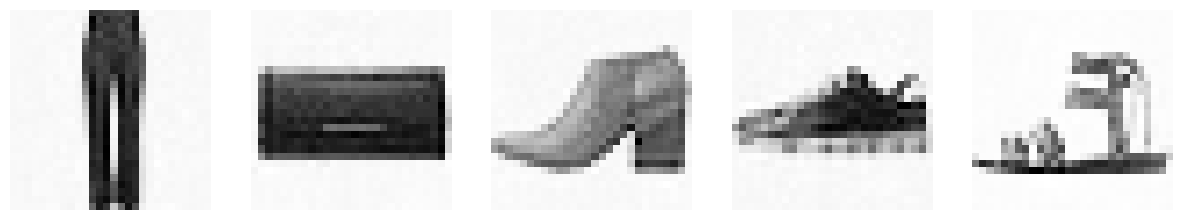

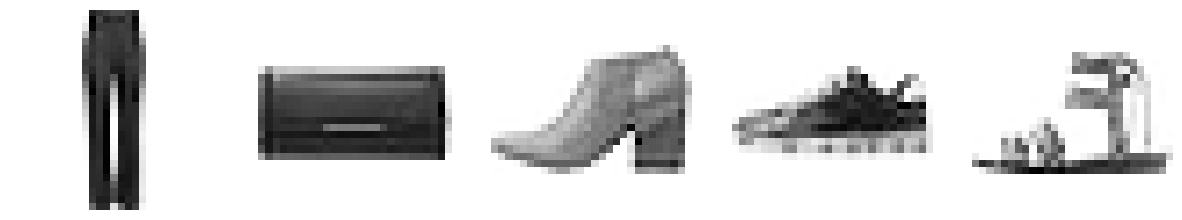

In [14]:
random_indices = random.sample(range(1000), 5)
distr_params = vad.dist_params[random_indices]
initial = train_ds[random_indices][1]

x = vad(distr_params)
restored = x.view(-1, 28, 28)

plot_tensors_as_images(restored)
plot_tensors_as_images(initial)

In [15]:
latent_vectors = vad.sample_vectors(vad.dist_params)
utils.plot_tsne(train_ds, latent_vectors, "VAD_TSNE_train")

<Figure size 800x600 with 0 Axes>

In [16]:
mu_init = torch.randn(NUM_CLASSES, Z_DIM, requires_grad=True)
sigma_init = 6 * torch.randn(NUM_CLASSES, Z_DIM, requires_grad=True)

labels = test_ds.y

mu = mu_init[labels]
sigma = sigma_init[labels]
params = torch.cat((mu,sigma),dim=1)
vad.dist_params = torch.nn.Parameter(params,True)

opt = torch.optim.Adam([vad.dist_params], lr=LEARNING_RATE)

res = evaluate.evaluate_model(vad, test_dl, opt, vad.dist_params, 500 , device)
print(res)
utils.plot_tsne(test_ds, vad.dist_params, "VAD_TSNE_test")


0.15256715565919876


<Figure size 800x600 with 0 Axes>